In [2]:
# importing pandas library
import pandas as pd


In [3]:
#step 1 importing a dataset

data = pd.read_csv("Lab02.csv", sep=',')

data.head(4)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057


In [ ]:
data.tail(4)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
550064,1006035,P00375436,F,26-35,1,C,3,0,20,NaN,NaN,371
550065,1006036,P00375436,F,26-35,15,B,4+,1,20,NaN,NaN,137
550066,1006038,P00375436,F,55+,1,C,2,0,20,NaN,NaN,365
550067,1006039,P00371644,F,46-50,0,B,4+,1,20,NaN,NaN,490


Число выбросов в Purchase: 2677
Размер выборки до удаления выбросов: (550068, 20)
Размер выборки после удаления выбросов: (547391, 20)



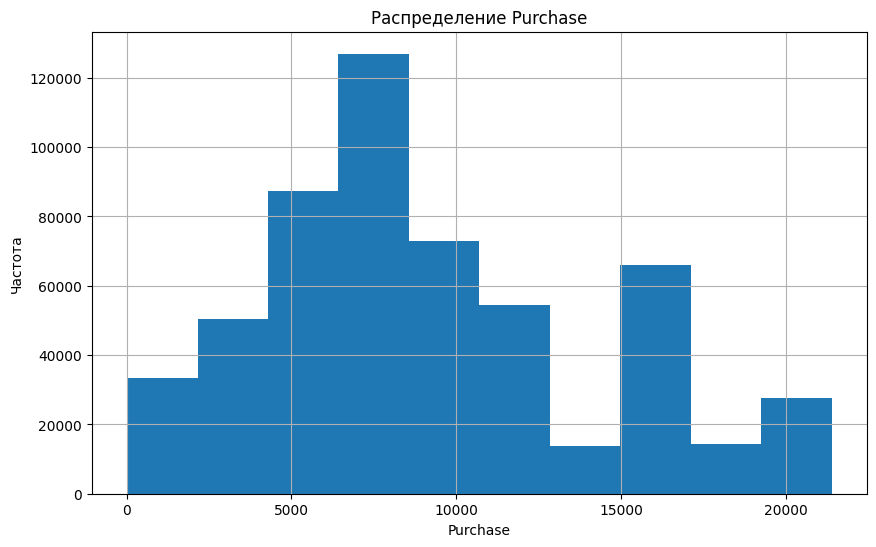

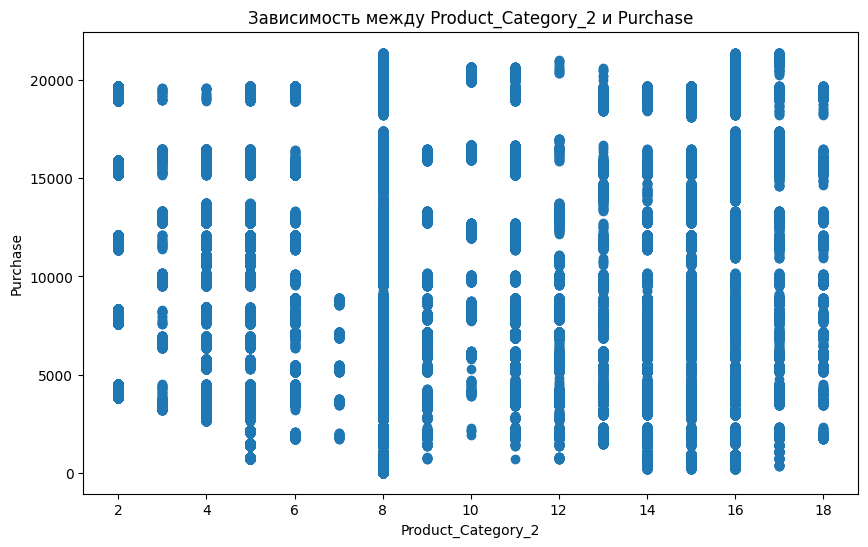

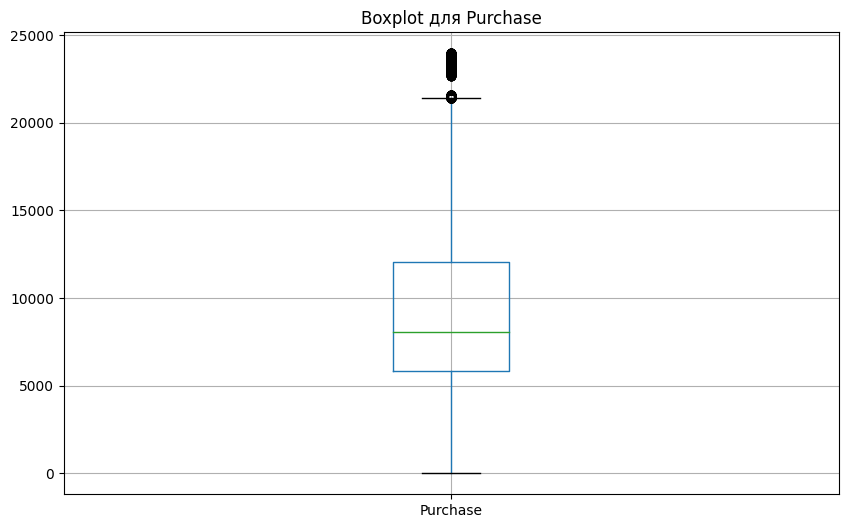

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

class DataPipeline:
    def __init__(self):
        self.modes = None

    def fit(self, data):
        # моды колонок 2 и 3
        self.modes = {
            'Product_Category_2': data['Product_Category_2'].mode()[0], # первая мода самая частая
            'Product_Category_3': data['Product_Category_3'].mode()[0]  # первая мода самая частая
        }

    def transform(self, data):
        # заполнить НаНы модами в колонках 2 и 3
        data['Product_Category_2'] = data['Product_Category_2'].fillna(self.modes['Product_Category_2'])
        data['Product_Category_3'] = data['Product_Category_3'].fillna(self.modes['Product_Category_3'])

        # добавить фичу - бинарный столбик с номером на гендер
        data['Gender_binary'] = data['Gender'].apply(lambda x: 1 if x == 'M' else 0)

        # Добавить фичу - бинарный столбик для статуса брака
        data['Marital_Status_binary'] = data['Marital_Status'].apply(lambda x: 1 if x == 1 else 0)

        # добавить фичу - столбик с номером на группировку по возрасту
        age_mapping = {'0-17': 0, '18-25': 1, '26-35': 2, '36-45': 3, '46-50': 4, '51-55': 5, '55+': 6}
        data['Age_encoded'] = data['Age'].map(age_mapping)

        # Добавить фичу - числовой формат для количества лет проживания
        data['Stay_In_Current_City_Years_numeric'] = data['Stay_In_Current_City_Years'].replace({'4+': 4}).astype(int)

        # добавить фичу - столбик с номером на город
        city_mapping = {'A': 0, 'B': 1, 'C': 2}
        data['City_Category_encoded'] = data['City_Category'].map(city_mapping)

        # Добавить фичу - количество уникальных продуктов, купленных пользователем
        data['Unique_Products_User'] = data.groupby('User_ID')['Product_ID'].transform('nunique')

        # добавить фичу - столбик со средней ценой покупок
        data['Avg_Purchase_User'] = data.groupby('User_ID')['Purchase'].transform('mean')

        # Добавить фичу - общая сумма покупок пользователя
        data['Total_Purchase_User'] = data.groupby('User_ID')['Purchase'].transform('sum')

        # выбрать и удалить выбросы покупок
        data_cleaned, outliers = self.identify_and_remove_outliers(data, 'Purchase')

        return data_cleaned, outliers

    def identify_and_remove_outliers(self, dataset, feature):
        # Метод для удаления выбросов с использованием IQR (межквартильный размах)
        first_quartile = dataset[feature].quantile(0.25)  # значение, ниже которого находится 25% данных / процентиль
        third_quartile = dataset[feature].quantile(0.75)   # значение, ниже которого находится 75% данных / процентиль
        interquartile_range = third_quartile - first_quartile  # Межквартильный размах
        lower_limit = first_quartile - 1.5 * interquartile_range  # Нижняя граница
        upper_limit = third_quartile + 1.5 * interquartile_range  # Верхняя граница

        # Определение выбросов
        outlier_data = dataset[(dataset[feature] < lower_limit) | (dataset[feature] > upper_limit)]
        print(f"Число выбросов в {feature}: {len(outlier_data)}")

        print(f"Размер выборки до удаления выбросов: {dataset.shape}")

        # Фильтрация данных, оставляя только записи без выбросов
        cleaned_data = dataset[(dataset[feature] >= lower_limit) & (dataset[feature] <= upper_limit)]
        print(f"Размер выборки после удаления выбросов: {cleaned_data.shape}")

        return cleaned_data, outlier_data

def visualize_data(clean_data, raw_data, outliers):
        print("")

        plt.figure(figsize=(10, 6))
        clean_data['Purchase'].hist(bins=10)
        plt.title('Распределение Purchase')
        plt.xlabel('Purchase')
        plt.ylabel('Частота')
        plt.show()

        print("")

        plt.figure(figsize=(10, 6))
        plt.scatter(clean_data['Product_Category_2'], clean_data['Purchase'], alpha=1.0)
        plt.title('Зависимость между Product_Category_2 и Purchase')
        plt.xlabel('Product_Category_2')
        plt.ylabel('Purchase')
        plt.show()

        print("")

        plt.figure(figsize=(10, 6))
        raw_data.boxplot(column='Purchase')
        plt.title('Boxplot для Purchase')
        plt.show()

data = pd.read_csv('Lab02.csv')

# Добавить моды
pipeline = DataPipeline()
pipeline.fit(data)

raw_data = data.copy()

# Добавить фичи и т.п
clean_data_final, outliers = pipeline.transform(data)

# Визуализировать новые данные
visualize_data(clean_data_final, raw_data, outliers)


In [ ]:

# Показать новые данные
clean_data_final.head(10)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,...,Purchase,Gender_binary,Marital_Status_binary,Occupation_encoded,Age_encoded,Stay_In_Current_City_Years_numeric,City_Category_encoded,Unique_Products_User,Avg_Purchase_User,Total_Purchase_User
0,1000001,P00069042,F,0-17,10,A,2,0,3,8.0,...,8370,0,0,NaN,0,2,0,35,9545.514286,334093
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,...,15200,0,0,NaN,0,2,0,35,9545.514286,334093
2,1000001,P00087842,F,0-17,10,A,2,0,12,8.0,...,1422,0,0,NaN,0,2,0,35,9545.514286,334093
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,...,1057,0,0,NaN,0,2,0,35,9545.514286,334093
4,1000002,P00285442,M,55+,16,C,4+,0,8,8.0,...,7969,1,0,NaN,6,4,2,77,10525.610390,810472
5,1000003,P00193542,M,26-35,15,A,3,0,1,2.0,...,15227,1,0,NaN,2,3,0,29,11780.517241,341635
6,1000004,P00184942,M,46-50,7,B,2,1,1,8.0,...,19215,1,1,NaN,4,2,1,14,14747.714286,206468
7,1000004,P00346142,M,46-50,7,B,2,1,1,15.0,...,15854,1,1,NaN,4,2,1,14,14747.714286,206468
8,1000004,P0097242,M,46-50,7,B,2,1,1,16.0,...,15686,1,1,NaN,4,2,1,14,14747.714286,206468
9,1000005,P00274942,M,26-35,20,A,1,1,8,8.0,...,7871,1,1,NaN,2,1,0,106,7745.292453,821001


In [ ]:
from google.colab import drive
drive.mount('/content/drive')